* Function
    * Raise_Question
    * Find_best_question
    * Partition
    * Build_tree
    * Predict
* Class
    * Attribute Node
    * Leaf Node

# Data Preparation - reorganize the data
1. label should be the last column
2. make sure that catagorical data are in string format, numerical data are in int or float format

In [10]:
# Import lib
# ===========================================================
import csv
from datascience import *
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC

import pandas as pd
import numpy as np
import random
import time
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
import collections
import math
import sys
from tqdm import tqdm
from time import sleep

In [31]:
# Initialize useful data
# ===========================================================
# with open('clinvar_conflicting_clean.csv', 'r') as f:
#     reader = csv.reader(f)
#     temp_rows = list(reader)
df = pd.read_csv('clinvar_conflicting_mapped.csv', low_memory=False)
# columns_to_change = ['ORIGIN', 'EXON', 'INTRON', 'STRAND', 'LoFtool', 'CADD_PHRED', 'CADD_RAW', 'BLOSUM62']
# df[['CLNVI', 'MC', 'SYMBOL', 'Feature_type', 'Feature', 'BIOTYPE', 
#  'cDNA_position', 'CDS_position', 'Protein_position', 'Amino_acids', 'Codons', 
#  'BAM_EDIT', 'SIFT', 'PolyPhen']] = df[['CLNVI', 'MC', 'SYMBOL', 'Feature_type', 'Feature', 'BIOTYPE', 
#  'cDNA_position', 'CDS_position', 'Protein_position', 'Amino_acids', 'Codons', 
#  'BAM_EDIT', 'SIFT', 'PolyPhen']].fillna(value="null")
df = df.sample(n = df.shape[0])
columns_backup = df.columns
df.astype({'CLASS': 'int32'})
all_rows = df.values.tolist()
row_num = len(all_rows)

In [14]:
# find caregorical columns
# ===========================================================
cate_columns = [0, 2, 3, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 23, 24, 25, 26, 27, 29, 30, 31]
# for i in range(len(all_rows[0])):
#     if isinstance(all_rows[0][i], str):
#         cate_columns.append(i)

In [15]:
# SMOTE Sampling for imbalanced input data
# ===========================================================
X_train = [row[: -1] for row in all_rows]
y_train = [row[-1] for row in all_rows]
smt = SMOTENC(random_state=42, categorical_features=cate_columns)
X_train, y_train = smt.fit_resample(X_train, y_train)

In [16]:
# Overwrite the original all_rows with the re-sampled data
# ===========================================================
all_rows = np.zeros((X_train.shape[0], X_train.shape[1] + 1))
all_rows[:, :X_train.shape[1]] = X_train
all_rows[:, X_train.shape[1]] = y_train
df = pd.DataFrame(all_rows)
df.columns = columns_backup

In [17]:
df.head()

,CHROM,POS,REF,ALT,AF_ESP,AF_EXAC,AF_TGP,CLNDISDB,CLNDN,CLNHGVS,...,Codons,STRAND,BAM_EDIT,SIFT,PolyPhen,LoFtool,CADD_PHRED,CADD_RAW,BLOSUM62,CLASS
0,0.125000,0.181969,0.591224,0.567686,0.000000,0.550472,0.000000,0.552848,0.898380,0.305961,...,0.670419,0.9375,0.333333,0.8,0.8,0.157729,0.585925,0.114138,0.000000,0.0
1,0.833333,0.943104,0.684758,0.799127,0.000000,0.000000,0.000000,0.821529,0.840281,0.167255,...,0.849617,0.9375,0.333333,0.6,0.2,0.378698,0.305972,0.559103,0.000429,0.0
2,0.000000,0.659701,0.578522,0.746725,0.171710,0.084296,0.903690,0.139701,0.039849,0.638078,...,0.344439,0.0625,0.333333,0.8,0.8,0.654216,0.702381,0.346329,0.000000,0.0
3,0.541667,0.842700,0.764434,0.567686,0.325123,0.989801,0.126018,0.665259,0.069870,0.833098,...,0.764070,0.9375,0.666667,0.8,0.8,0.973558,0.859351,0.412343,0.999747,1.0
4,0.416667,0.609950,0.578522,0.799127,0.026742,0.262337,0.459990,0.288932,0.232505,0.449837,...,0.431337,0.0625,0.666667,0.8,0.8,0.008691,0.899770,0.263903,0.000000,0.0


# Classification with Supervised Learning: Decision Tree

In [24]:
# Decision stump part for Adaboost
# ===========================================================
def is_numeric(value):
    return isinstance(value, int) or isinstance(value, float)

# === LeafNode is the prediction result of this branch ===
class LeafNode:
    def __init__(self, rows):
        labels = [row[-1] for row in rows]
        self.prediction = collections.Counter(labels)

# === DecisionNode is an attribute / question used to partition the data ===
class DecisionNode:
    def __init__(self, question = None, left_branch = None, right_branch = None):
        self.question = question
        self.left_branch = left_branch
        self.right_branch = right_branch
    
class DecisionTree:
    def __init__(self, training_attribute, training_data, method = "CART"):
        self.attribute = training_attribute     # takein attribute and data separately
        self.train = training_data[1:]
        self.row_num = len(self.train)
        self.column_num = len(self.attribute)
        self.method = method.upper()            # convert to upper case for general use
        self.labels = self.uniq_val(-1)
        if self.method not in ["C4.5", "CART", "HYBRID"]:
            print("Error: Please choose a valid method!")
            return None
        self.root = self.build_tree(self.train)
    
    def uniq_val(self, column):
        return set([self.train[i][column] for i in range(len(self.train))])
    
    # when raising a question.
    # if it's a categorical attribute, we simply iterate all categories
    # if it's a numeric attribute, we iterate the set of possible numeric values 
    class Question:
        def __init__(self, column, ref_value, attribute):
            self.column = column
            self.ref_value = ref_value if ref_value else "None"
            self.attri = attribute
            # i hard-coded the categorical columns idx
            self.cate_columns = [0, 2, 3, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 23, 24, 25, 26, 27, 29, 30, 31]

        def match(self, row):
            if is_numeric(self.ref_value) and self.column not in self.cate_columns:
                try:
                    return row[self.column] >= self.ref_value
                except:
                    print("Error occured in ", row)
                    return True
            else:
                return row[self.column] == self.ref_value

        def __repr__(self):
            operand = ">=" if is_numeric(self.ref_value) else "=="
            return "Is %s %s %s?" % (self.attri[self.column], operand, str(self.ref_value))
    
    # === Method 1 - C4.5 ===
    def entropy(self, rows):
        # === Bits used to store the information ===
        labels = [row[-1] for row in rows]
        frequency = collections.Counter(labels).values()
        pop = sum(frequency)
        H = 0
        for f in frequency:
            p = f / pop
            H -= p * math.log(p, 2)
        return H
    
    # === Method 2 - CART ===
    def gini(self, rows):
        # === Probability of misclassifying any of your label, which is impurity ===
        labels = [row[-1] for row in rows]
        frequency = collections.Counter(labels).values()
        pop = sum(frequency)
        gini = 1
        for f in frequency:
            p = f / pop
            gini -= p ** 2
        return gini
    
    # === Calculate Gain Info ===
    def info(self, branches, root):
        # === Objective: to find the best question which can maximize info ===
        root_size = float(len(root))
        if self.method == "C4.5":  # Here I pick the GainRatio Approach
            root_uncertainty = self.entropy(root)
            gain_info = root_uncertainty
            split_info = 0
            for branch in branches:
                if not branch: continue
                gain_info -= len(branch) / root_size * self.entropy(branch)
                split_info -= float(len(branch)) / root_size * math.log(float(len(branch)) / root_size)
#                 print(gain_info, split_info)
            return gain_info / split_info
        elif self.method == "CART":
            root_uncertainty = self.gini(root)
            gain_info = root_uncertainty
            for branch in branches:
                if not branch: continue
                gain_info -= len(branch) / root_size * self.gini(branch)
            return gain_info
        elif self.method == "HYBRID":
            pass
        pass
    
    # === Here I only do Binary Partitions ===
    def partition(self, rows, question):
        true_rows = []
        false_rows = []
        for row in rows:
            if question.match(row):
                true_rows.append(row)
            else:
                false_rows.append(row)
        return true_rows, false_rows
    
    def find_best_question(self, rows):
        max_info_attenuation = 0
        best_question = self.Question(0, self.train[0][0], self.attribute)
        # === Iterate through all question candidates ===
        # === TODO: Maybe Iteration here can be optimized ===
        for col in range(self.column_num - 1): # minus 1 to avoid using the label as attribute
            ref_candidates = self.uniq_val(col)
            for ref_value in ref_candidates:
                if ref_value == "null": continue # avoid using null values to generate a question
                q = self.Question(col, ref_value, self.attribute)
                temp_true_rows, temp_false_rows = self.partition(rows, q)
                temp_info_attenuation = self.info([temp_true_rows, temp_false_rows], rows)
                if temp_info_attenuation >= max_info_attenuation:
                    max_info_attenuation = temp_info_attenuation
                    best_question = q
        return max_info_attenuation, best_question
        
    # === Input rows of data with attributes and labels ===
    def build_tree(self, rows):
        # === Assign all rows as root of the whole decision tree ===
        # === We have met the leaf node if gini(rows) is 0 or no question candidates left ===
        gain_reduction, q = self.find_best_question(rows)
#         if gain_reduction <= 0.003:
        if self.gini(rows) <= 0.255:
            return LeafNode(rows)
        true_rows, false_rows = self.partition(rows, q)
        # === Recursion after we have found a optimal question ===
        return DecisionNode(q, self.build_tree(true_rows), self.build_tree(false_rows))
    
    # === Input a row of data with attributes (and no label), predict its label with our decision tree ===
    # === Actually it can contain a label, we just don't use it ===
    # === walk down the decision tree until we reach the leaf node ===
    def classify(self, row, node):
        if isinstance(node, LeafNode):
#             print("===", node.prediction)
            return node.prediction
        
        if node.question.match(row):
#             print(node.question, True)
            return self.classify(row, node.left_branch)
        else:
#             print(node.question, False)
            return self.classify(row, node.right_branch)
    
    def print_tree(self, node, spacing=""):
        # Base case: we've reached a leaf
        if isinstance(node, LeafNode):
            print (spacing + "Predict", node.prediction)
            return

        # Print the question at this node
        print (spacing + str(node.question))

        # Call this function recursively on the true branch
        print (spacing + '--> True:')
        self.print_tree(node.left_branch, spacing + "  ")

        # Call this function recursively on the false branch
        print (spacing + '--> False:')
        self.print_tree(node.right_branch, spacing + "  ")

In [25]:
# Divide whole dataset into training set and testing set
# ===========================================================
training_percentage = 0.01  # percent of partition of training dataset
training_size = int(row_num * training_percentage)
testing_size = row_num - training_size
training_attribute = list(df.columns)
training_data = all_rows[: training_size]  # training data should include header row
testing_data = all_rows[training_size: ]   # testing data don't need to include header row

In [26]:
# Training
# ===========================================================
start = time.time()
tree = DecisionTree(training_attribute, training_data, "CART")
end = time.time()
print("Decision Tree Trained! Time: %.03fs" % (end - start))

Decision Tree Trained! Time: 60.490s


In [27]:
# tree.print_tree(tree.root)

In [28]:
# Testing and Computing TN, TP, FN, FP, etc. 
# ===========================================================
ROC = Table(make_array('CUTOFF', 'TN', 'FN', 'FP', 'TP', 'ACC'))
step_size = 0.05
CMap = {0: 'TN', 1: 'FN', 2: 'FP', 3: 'TP'}
# 00(0) -> TN
# 01(1) -> FN
# 10(2) -> FP
# 11(3) -> TP
for cutoff in np.arange(0, 1 + step_size, step_size):
    sys.stdout.write('\r')
    # the exact output you're looking for:
    sys.stdout.write("Testing: [%-20s] %d%%" % ('='*int(cutoff * 100 / 5), int(cutoff * 100)))
    sys.stdout.flush()
    Confusion = {'TN': 0, 'FN': 0, 'FP': 0, 'TP': 0}
    for row in testing_data:
        # prediction is a counter of label 1 and 0
        pred_counter = tree.classify(row, tree.root)
        true_rate = pred_counter.get(1, 0) / (pred_counter.get(1, 0) + pred_counter.get(0, 0) + 0.00000001)
#         print(true_rate)
        true_pred = 1 if true_rate >= cutoff else 0
        indicator = (true_pred << 1) + row[-1]
        # accordingly update confusion matrix
        Confusion[CMap[indicator]] += 1
    # concatenate the confusion matrix values into the overall ROC Table
    thisline = [cutoff] + list(Confusion.values()) + [(Confusion['TP'] + Confusion['TN']) / sum(Confusion.values())]
    ROC = ROC.with_row(thisline)
ROC = ROC.with_column('SENSITIVITY', ROC.apply(lambda TP, FN: TP / (TP + FN + 0.00000001), 'TP', 'FN'))
ROC = ROC.with_column('FPR', ROC.apply(lambda TN, FP: FP / (TN + FP + 0.00000001), 'TN', 'FP'))
ROC = ROC.with_column('FMEAS', ROC.apply(lambda TP, FP, FN: 2 * (TP / (TP + FN)) * (TP / (TP + FP)) / (TP / (TP + FN) + TP / (TP + FP)), 'TP', 'FP', 'FN'))

Testing: [====================] 100%

/Users/frostace/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in long_scalars


In [29]:
# show
ROC.show()

CUTOFF,TN,FN,FP,TP,ACC,SENSITIVITY,FPR,FMEAS
0,0,0,48263,48594,0.501709,1,1,0.668184
0.05,4591,6077,43672,42517,0.486366,0.874943,0.904875,0.630896
0.1,7593,9949,40670,38645,0.477384,0.795263,0.842675,0.604258
0.15,41232,39063,7031,9531,0.524103,0.196135,0.145681,0.292559
0.2,41232,39063,7031,9531,0.524103,0.196135,0.145681,0.292559
0.25,41232,39063,7031,9531,0.524103,0.196135,0.145681,0.292559
0.3,41232,39063,7031,9531,0.524103,0.196135,0.145681,0.292559
0.35,41232,39063,7031,9531,0.524103,0.196135,0.145681,0.292559
0.4,41232,39063,7031,9531,0.524103,0.196135,0.145681,0.292559
0.45,41232,39063,7031,9531,0.524103,0.196135,0.145681,0.292559


In [12]:
# Acc Curve by cutoff
# ===========================================================
matplotlib.use('TkAgg')
fig = plt.figure()
plt.xlabel('Cutoff')
plt.ylabel('Accuracy')
plt.title('Accuracy - Cutoff of Decision Tree')
plt.plot(ROC.column('CUTOFF'), ROC.column('ACC'), color='orange')
plt.show()
fig.savefig('Decision Tree ACC - SMOTE.png', bbox_inches='tight')

In [13]:
# ROC_CURVE
# ===========================================================
fig = plt.figure()
plt.xlabel('False Positive Rate')
plt.ylabel('Sensitivity')
plt.title('ROC - Curve of Decision Tree')
plt.plot(ROC.column('FPR'), ROC.column('SENSITIVITY'), color='orange')
plt.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), color='black')
plt.legend(['Decision Tree', 'Null'])
plt.axis([0, 1, 0, 1])
plt.show()
fig.savefig('Decision Tree ROC - SMOTE.png', bbox_inches='tight')

In [14]:
# Compute AUC
# ===========================================================
length = len(ROC.column('FPR'))
auc = 0
for i in range(length - 1):
    auc += 0.5 * abs(ROC.column('FPR')[i + 1] - ROC.column('FPR')[i]) * (ROC.column('SENSITIVITY')[i] + ROC.column('SENSITIVITY')[i + 1])
print("auc = %.03f" %auc)

auc = 0.511


In [15]:
# Original Testing
# ===========================================================

accuracy = []
for row in testing_data:
    classification = tree.classify(row, tree.root)
    if len(classification) == 1:
        accuracy.append(int(classification.get(row[-1], 0) > 0))
    else:
        tot = sum(classification.values())
        accuracy.append(classification.get(row[-1], 0) / tot)
print(sum(accuracy) / len(accuracy))

0.5096998668139628


In [16]:
# My Decision Tree Model - before SMOTE
# ===========================================================
result = np.array([[0.1, 0.6052853830443929, 0.6341292591846538, 6.658, 0.2575948238372803], 
[0.2, 0.6696793630299119, 0.6462675119355091, 15.636898589134216, 0.26355624198913574], 
[0.3, 0.688320280645608, 0.6270048866889123, 15.349877572059631, 0.2788889408111572], 
[0.4, 0.6926441596845737, 0.6461577795177449, 17.142344093322755, 0.3045179843902588], 
[0.5, 0.7249279250111773, 0.6423258893248721, 20.893156909942626, 0.3267941474914551], 
[0.6, 0.6908789196403483, 0.6319173588785352, 23.121678400039674, 0.3292832374572754], 
[0.7, 0.6911146321003911, 0.6490688659793814, 26.19135489463806, 0.3296070098876953], 
[0.8, 0.681758435172271, 0.6396528437797009, 29.576567125320434, 0.3475379943847656], 
[0.9, 0.6796756798972815, 0.6486733420990525, 36.53753626346588, 0.37729477882385254], 
[1, 0.678894111630874, 0.6433185614453725, 40.28847301006317, 0.3777620792388916]])

# SMOTE-Sklearn
'''
Training: rate = 0.001
0.5655408526757759 0.7647023916244506
Training: rate = 0.002
0.5763186830125472 0.810082483291626
Training: rate = 0.003
0.5810638166556946 0.8108757019042969
Training: rate = 0.004
0.5885314771721 0.8401288032531739
Training: rate = 0.005
0.594624875027056 0.7966373920440674
Training: rate = 0.006
0.5983048399244761 0.810550308227539
Training: rate = 0.007
0.5991149071530374 0.7834853887557983
Training: rate = 0.008
0.5999245306426267 0.8016273975372314
Training: rate = 0.009
0.602349142614689 0.815482497215271
Training: rate = 0.010
0.606779028933111 0.8005533218383789
Training: rate = 0.011
0.6092797295615745 0.822369909286499
Training: rate = 0.012
0.603282193942162 0.7970266103744507
Training: rate = 0.013
0.6062842239793851 0.8196890115737915
Training: rate = 0.014
0.612003994050529 0.8205815076828002
Training: rate = 0.015
0.6121868687920371 0.8276321887969971
Training: rate = 0.016
0.6111133113769959 0.8073604106903076
Training: rate = 0.017
0.6134323063922129 0.8315609693527222
Training: rate = 0.018
0.6167733648031916 0.7991121768951416
Training: rate = 0.019
0.6123630509325083 0.8169927835464478
Training: rate = 0.020
0.6138774356935055 0.8319643974304199
Training: rate = 0.021
0.620447093577482 0.8392762184143067
Training: rate = 0.022
0.617440726487212 0.8286631107330322
Training: rate = 0.023
0.6190865576386119 0.8347836017608643
Training: rate = 0.024
0.620091837592468 0.8286760091781616
Training: rate = 0.025
0.6166549210589981 0.8302491903305054
Training: rate = 0.026
0.6192781106209132 0.8354895114898682
Training: rate = 0.027
0.6234326910915299 0.8257789850234986
Training: rate = 0.028
0.6213762687543524 0.8454999923706055
Training: rate = 0.029
0.6224406163855473 0.8318482160568237
Training: rate = 0.030
0.6263430003277545 0.8428296327590943
Training: rate = 0.031
0.6237220328937619 0.8406438112258912
Training: rate = 0.032
0.6236777980251726 0.8662947177886963
Training: rate = 0.033
0.626026874250989 0.8328955888748169
Training: rate = 0.034
0.6257152866985869 0.8468024969100952
Training: rate = 0.035
0.6265346029586805 0.8474492788314819
Training: rate = 0.036
0.6265112023660077 0.8620473861694335
Training: rate = 0.037
0.6261200626191414 0.8301334857940674
Training: rate = 0.038
0.6280779932411543 0.8524049997329712
Training: rate = 0.039
0.6299500565598788 0.8645250082015992
Training: rate = 0.040
0.6299888898384753 0.8536231279373169
Training: rate = 0.041
0.6284469206831281 0.8789537906646728
Training: rate = 0.042
0.6301703189063621 0.8516392946243286
Training: rate = 0.043
0.6301845342706504 0.9003715276718139
Training: rate = 0.044
0.6306550237078676 0.8652402877807617
Training: rate = 0.045
0.6300125642980638 0.8881727933883667
Training: rate = 0.046
0.6320157380432796 0.8888829946517944
Training: rate = 0.047
0.6337440544088844 0.8905789136886597
Training: rate = 0.048
0.6314883440341277 0.9063771963119507
Training: rate = 0.049
0.6352967184652383 0.872174596786499
Training: rate = 0.050
0.6362192739088661 0.8944581747055054
Training: rate = 0.051
0.635050142647186 0.8893932819366455
Training: rate = 0.052
0.636382223760791 0.909731411933899
Training: rate = 0.053
0.6355432581410209 0.8765779972076416
Training: rate = 0.054
0.6350010298884469 0.9234981298446655
Training: rate = 0.055
0.6367308401883967 0.8912766933441162
Training: rate = 0.056
0.6363679819224752 0.92429518699646
Training: rate = 0.057
0.6361072745266502 0.9316825151443482
Training: rate = 0.058
0.6380303310724746 0.9281157970428466
Training: rate = 0.059
0.6376651118183008 119.9494647026062
Training: rate = 0.060
0.6377522965807676 0.9300302028656006
Training: rate = 0.061
0.6386507355751905 53.10061490535736
Training: rate = 0.062
0.6398423406186109 0.9783363103866577
Training: rate = 0.063
0.6401926339407871 0.959096097946167
Training: rate = 0.064
0.6385852653723101 0.9369389057159424
Training: rate = 0.065
0.6390797411429199 0.9149164199829102
Training: rate = 0.066
0.641498578063751 1.0091386079788207
Training: rate = 0.067
0.6404528716680407 1.0058871030807495
Training: rate = 0.068
0.64043662932723 1.021292805671692
Training: rate = 0.069
0.6405981493721085 1.0185524940490722
Training: rate = 0.070
0.6397086554260445 1.0047208070755005
Training: rate = 0.071
0.6421714411878348 1.0170202732086182
Training: rate = 0.072
0.6443274246308903 1.0246572017669677
Training: rate = 0.073
0.6423188405797101 1.0550734043121337
Training: rate = 0.074
0.6412723023933196 1.0291611909866334
Training: rate = 0.075
0.6417295858972226 0.9422451972961425
Training: rate = 0.076
0.6432240449288553 0.969203782081604
Training: rate = 0.077
0.6443322222222222 0.9420042991638183
Training: rate = 0.078
0.6418161796603006 0.9857431173324585
Training: rate = 0.079
0.6444841601247147 0.9456622123718261
Training: rate = 0.080
0.6430842288313193 0.954564905166626
'''

[percentage, my_acc, sklearn_acc, my_time_cost, sklearn_time_cost] = result.transpose()
# sklearn_acc = [0.5691256634261018, 0.5776658822562248, 0.5827950131665569, 0.5793117650692972, 0.5897413961925768, 0.5923227716847395, 0.5946543283828725, 0.5993445538003475, 0.6014871004129109, 0.6039810220339158]
# sklearn_time_cost = [0.7889662265777588, 0.8384890079498291, 0.84961838722229, 0.8846114873886108, 0.8440592765808106, 0.8550214767456055, 0.8227906942367553, 0.8494516849517822, 0.8404701948165894, 0.8558013916015625]

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Training Data Percentage(%)')
ax1.set_ylabel('Time Consumption(s)', color=color)
ax1.plot(percentage, my_time_cost, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:green'
ax2.set_ylabel('My Model - Accuracy', color=color)  # we already handled the x-label with ax1
ax2.plot(percentage, my_acc, color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.ylim(0, 1)
plt.title('My Decision Tree Performance - SMOTE')
# plt.legend(['Time Consumption', 'My ACC'])
fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.savefig('Decision Tree Time & Acc by Training percentage - SMOTE.png', bbox_inches='tight')
plt.show()

NameError: name 'percentage' is not defined

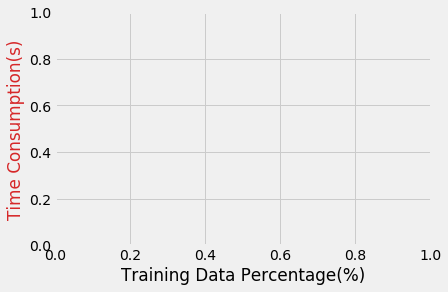

In [5]:
# Sklearn Decision Tree Model - before SMOTE
# ===========================================================
fig, ax3 = plt.subplots()

color = 'tab:red'
ax3.set_xlabel('Training Data Percentage(%)')
ax3.set_ylabel('Time Consumption(s)', color=color)
ax3.plot(percentage, sklearn_time_cost, color=color)
ax3.tick_params(axis='y', labelcolor=color)
plt.ylim(0, 1)

ax4 = ax3.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:green'
ax4.set_ylabel('Sklearn - Accuracy', color=color)  # we already handled the x-label with ax1
ax4.plot(percentage, sklearn_acc, color=color)
ax4.tick_params(axis='y', labelcolor=color)
plt.ylim(0, 1)
plt.title('Sklearn Decision Tree Performance - SMOTE')
# plt.legend(['Time Consumption', 'Sklearn ACC'])
fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.savefig('Decision Tree Time & Sklearn Acc by Training percentage - SMOTE.png', bbox_inches='tight')
plt.show()

In [18]:
# 2 Models Comparison - Time Consumption
# ===========================================================
fig = plt.figure()
plt.xlabel('Training Data Percentage(%)')
plt.ylabel('Time Consumption(s)')
plt.title('Decision Tree Time Consumption')
plt.plot(percentage, my_time_cost, color='orange')
plt.plot(percentage, sklearn_time_cost, color='black')
plt.legend(['My Model', 'Sklearn Model'])
plt.axis([0, 1, -5, 45])
plt.show()
fig.savefig('Decision Tree Time Consumption Comparison - SMOTE.png', bbox_inches='tight')

In [19]:
# 2 Models Comparison - Accuracy
# ===========================================================
fig = plt.figure()
plt.xlabel('Training Data Percentage(%)')
plt.ylabel('Accuracy')
plt.title('Decision Tree Accuracy')
plt.plot(percentage, my_acc, color='orange')
plt.plot(percentage, sklearn_acc, color='black')
plt.legend(['My Model: Avg = 68.0%', 'Sklearn Model: Avg = 64.1%'])
plt.axis([0, 1, 0, 1])
plt.show()
fig.savefig('Decision Tree Accuracy Comparison - SMOTE.png', bbox_inches='tight')

In [20]:
label_distrib = dict()
for row in all_rows:
    label_distrib[row[-1]] = label_distrib.get(row[-1], 0) + 1
print("label_distribution", label_distrib)

label_distribution {0.0: 48754, 1.0: 48754}


In [21]:
# === toy data set ===
training_data = [
    ['Color', 'Diameter', 'Label'],
    ['Green', 3, 'Apple'],
    ['Yellow', 3, 'Apple'],
    ['Red', 1, 'Grape'],
    ['Red', 1, 'Grape'],
    ['Yellow', 3, 'Lemon'],
]
testing_data = [
    ['Red', 2, 'Grape'],
    ['Yellow', 3.5, 'Apple'],
    ['Green', 3, 'Apple']
]

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [24]:
# sklearn lib version
# ===========================================================
from sklearn import tree
df = pd.read_csv('clinvar_conflicting_clean.csv', low_memory=False)
df.fillna(0,inplace=True)
df.head()
df = df.sample(n = df.shape[0])
all_rows = df.values.tolist()
row_num = len(all_rows)

# balancing 
# ===========================================================
g = df.groupby('CLASS')
df_balanced = g.apply(lambda x: x.sample(g.size().min()).reset_index(drop=True))
# Extract smaller sample to avoid memory error later, when training starts
df_balanced = df_balanced.sample(1000)

# spliting data to training and testing
# ===========================================================
X = df_balanced.drop('CLASS',axis=1)
# One hot encoding
X = pd.get_dummies(X, drop_first=True)
y = df_balanced['CLASS']
y = pd.get_dummies(y, drop_first=True)

# Train/test split
train_X, test_X, train_y, test_y = train_test_split(X, y)

# Normalize using StandardScaler
scaler=StandardScaler()
train_X=scaler.fit_transform(train_X)
test_X=scaler.transform(test_X)

# testing acc
model = DecisionTreeClassifier()
model.fit(train_X, train_y)
pred_y = model.predict(test_X)


In [28]:
score = accuracy_score(test_y, pred_y)
confusion = confusion_matrix(test_y, pred_y)
report = classification_report(test_y, pred_y)

In [29]:
report

'              precision    recall  f1-score   support\n\n           0       0.60      0.61      0.61       116\n           1       0.66      0.65      0.65       134\n\n    accuracy                           0.63       250\n   macro avg       0.63      0.63      0.63       250\nweighted avg       0.63      0.63      0.63       250\n'

In [ ]:
test = [row[: -1] for row in testing_data]
actual_label = [row[-1] for row in testing_data]
result = clf.predict(test)

In [ ]:
accuracy = 0
for i in range(len(result)):
    accuracy += int(result[i] == actual_label[i])
accuracy /= len(result)
accuracy

In [ ]:
np.average(sklearn_acc)

In [ ]:
counter = collections.Counter()
for val in y_train:
    counter[val] = counter.get(val, 0) + 1

In [ ]:
counter

In [ ]:
len(cate_columns)

In [ ]:
from collections import Counter
from numpy.random import RandomState
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTENC
X, y = make_classification(n_classes=2, class_sep=2,
weights=[0.1, 0.9], n_informative=3, n_redundant=1, flip_y=0,
n_features=20, n_clusters_per_class=1, n_samples=1000, random_state=10)
print('Original dataset shape (%s, %s)' % X.shape)

print('Original dataset samples per class {}'.format(Counter(y)))

# simulate the 2 last columns to be categorical features
X[:, -2:] = RandomState(10).randint(0, 4, size=(1000, 2))
sm = SMOTENC(random_state=42, categorical_features=[18, 19])
X_res, y_res = sm.fit_resample(X, y)
print('Resampled dataset samples per class {}'.format(Counter(y_res)))

In [ ]:
np.average(my_time_cost)

In [ ]:
# conpare balanced and unbalanced
